# Plot learning curve of random forest with different max depts choices

In [10]:


import time

import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearnex import patch_sklearn

patch_sklearn()
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv  # noqa
# now you can import normally from model_selection
from sklearn.model_selection import train_test_split
from drowsiness_detection.data import (get_feature_data, preprocess_feature_data,
                                       session_type_mapping)
from drowsiness_detection import config
from sklearn.model_selection import StratifiedKFold

config.set_paths(30, 60)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [11]:
n_splits = 2
seed = 123
test_size = .2
num_targets = 2
exclude_by = 'a'

data = get_feature_data(data_path=config.PATHS.WINDOW_FEATURES)
X, y = preprocess_feature_data(feature_data=data,
                               exclude_sess_type=session_type_mapping[exclude_by],
                               num_targets=num_targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                    random_state=seed)

scaler = StandardScaler()
num_samples = -1

X_train_scaled = scaler.fit_transform(X_train, y_train)[:num_samples]
X_test_scaled = scaler.transform(X_test)[:num_samples]

In [13]:


def track_errors_while_increasing_tree(model_params, X_train, X_test, y_train, y_test,
                                       n_estimator_options):
    test_errors = []
    train_errors = []

    classifier = RandomForestClassifier(**model_params)
    for added_estimators in n_estimator_options:
        # print(f" number of estimators: old -> {classifier.n_estimators}, new: {int(added_estimators)}")
        classifier.n_estimators = int(added_estimators)

        classifier.fit(X_train_scaled, y_train[:num_samples])
        y_hat_train = classifier.predict(X_train)
        y_hat_test = classifier.predict(X_test)

        train_errors.append(accuracy_score(y_train[:num_samples], y_hat_train))
        test_errors.append(accuracy_score(y_test[:num_samples], y_hat_test))
    return train_errors, test_errors


max_depths_options = [35, 50, 80, 120, 180]
n_estimator_options = np.logspace(2, 9, num=10, base=2)
print("options: ", n_estimator_options)

all_train_errors, all_test_errors = [], []
for max_depth in max_depths_options:
    model_params = {'criterion': 'entropy', 'max_depth': max_depth, 'max_features': 'sqrt',
                    'n_estimators': 1, 'warm_start': True, 'n_jobs': -2}

    start = time.time()
    train_errors, test_errors = track_errors_while_increasing_tree(model_params=model_params,
                                                                   n_estimator_options=n_estimator_options,
                                                                   X_train=X_train_scaled,
                                                                   X_test=X_test_scaled,
                                                                   y_train=y_train, y_test=y_test)
    print(f"runinng with max depth {max_depth} took {time.time() - start} secs.")

    all_train_errors.append(train_errors)
    all_test_errors.append(test_errors)



options:  [  4.           6.85795186  11.75787594  20.1587368   34.56191164
  59.25598159 101.59366733 174.18112002 298.63143413 512.        ]
runinng with max depth 35 took 67.57142329216003 secs.
runinng with max depth 50 took 69.04464817047119 secs.
runinng with max depth 80 took 68.84917449951172 secs.
runinng with max depth 120 took 69.38657808303833 secs.
runinng with max depth 180 took 70.79360461235046 secs.


In [14]:
import json

with open(f"max_depth_scores-{time.strftime('%H-%M-%S')}.json", "w") as fp:
    json.dump([all_train_errors, all_test_errors], fp)

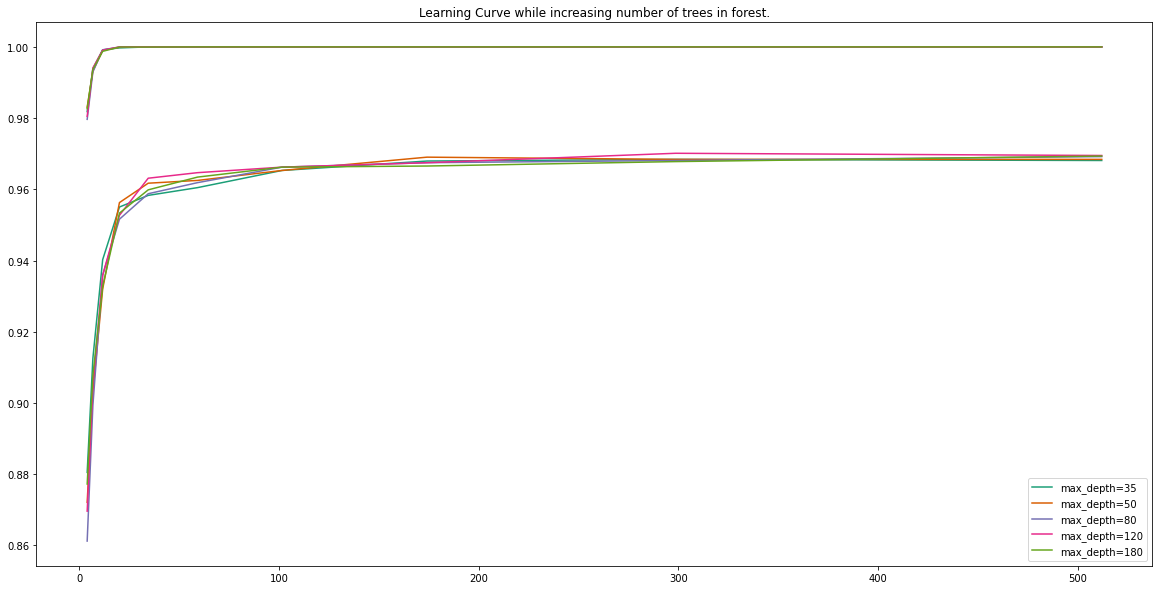

In [15]:
def plot_learning_curve_from_errors_with_options(train_errors, test_errors, n_estimator_options,
                                                 ax=None, color=None, name=""):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title("Learning Curve while increasing number of trees in forest.")
    ax.plot(n_estimator_options, train_errors, color=color)
    ax.plot(n_estimator_options, test_errors, label=name, color=color)
    _ = ax.legend()


plt.rcParams["figure.figsize"] = 20, 10
fig, ax = plt.subplots()
colors = plt.cm.Dark2.colors

for train_errors, test_errors, color, max_depth in zip(all_train_errors, all_test_errors, colors,
                                                       max_depths_options):
    plot_learning_curve_from_errors_with_options(train_errors=train_errors, test_errors=test_errors,
                                                 n_estimator_options=n_estimator_options, ax=ax,
                                                 color=color, name=f"max_depth={max_depth}")